In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Load the cleaned data from the previous step
df_clean = pd.read_csv('../data/processed/cleaned_survey.csv')

print("Cleaned data loaded successfully!")
df_clean.head()

Cleaned data loaded successfully!


,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
0,37,Female,United States,No,No,Yes,Often,6-25,No,Yes,...,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
1,44,Male,United States,No,No,No,Rarely,More than 1000,No,No,...,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
2,32,Male,Canada,No,No,No,Rarely,6-25,No,Yes,...,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
3,31,Male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,...,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
4,31,Male,United States,No,No,No,Never,100-500,Yes,Yes,...,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No


In [2]:
# Encoding categorical variables
# Select columns for one-hot encoding
columns_to_one_hot_encode = [
    'no_employees', 'work_interfere', 'mental_health_consequence',
    'phys_health_consequence', 'Country', 'Gender'
]

# Use pandas get_dummies for one-hot encoding
# drop_first=True helps to reduce multicollinearity
model_df = pd.get_dummies(df_clean, columns=columns_to_one_hot_encode, drop_first=True)

print("Shape of the final dataframe:", model_df.shape)
model_df.head()

Shape of the final dataframe: (1259, 79)


,Age,self_employed,family_history,treatment,remote_work,tech_company,benefits,care_options,wellness_program,seek_help,...,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_United Kingdom,Country_United States,Country_Uruguay,Country_Zimbabwe,Gender_Male,Gender_Other
0,37,No,No,Yes,No,Yes,Yes,Not sure,No,Yes,...,False,False,False,False,False,True,False,False,False,False
1,44,No,No,No,No,No,Don't know,No,Don't know,Don't know,...,False,False,False,False,False,True,False,False,True,False
2,32,No,No,No,No,Yes,No,No,No,No,...,False,False,False,False,False,False,False,False,True,False
3,31,No,Yes,Yes,No,Yes,No,Yes,No,No,...,False,False,False,False,True,False,False,False,True,False
4,31,No,No,No,Yes,Yes,Yes,No,Don't know,Don't know,...,False,False,False,False,False,True,False,False,True,False


In [6]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Age                             1259 non-null   int64 
 1   self_employed                   1259 non-null   object
 2   family_history                  1259 non-null   object
 3   treatment                       1259 non-null   object
 4   remote_work                     1259 non-null   object
 5   tech_company                    1259 non-null   object
 6   benefits                        1259 non-null   object
 7   care_options                    1259 non-null   object
 8   wellness_program                1259 non-null   object
 9   seek_help                       1259 non-null   object
 10  anonymity                       1259 non-null   object
 11  leave                           1259 non-null   object
 12  coworkers                       1259 non-null   

In [7]:
# Feature Engineering

# --- 1. Correctly Encode Support-Related Columns ---

# Simple Yes/No/Don't know mapping: Yes=1, No=0, Don't know=0
binary_map = {'Yes': 1, 'No': 0, "Don't know": 0}
df_clean['benefits'] = df_clean['benefits'].map(binary_map)
df_clean['wellness_program'] = df_clean['wellness_program'].map(binary_map)
df_clean['seek_help'] = df_clean['seek_help'].map(binary_map)
df_clean['anonymity'] = df_clean['anonymity'].map(binary_map)

# Ordinal mapping for 'leave': Higher score = more supportive
leave_map = {'Very easy': 4, 'Somewhat easy': 3, "Don't know": 2, 'Somewhat difficult': 1, 'Very difficult': 0}
df_clean['leave'] = df_clean['leave'].map(leave_map)

# Also encode our target variable 'treatment'
df_clean['treatment'] = df_clean['treatment'].map({'Yes': 1, 'No': 0})
print("Columns successfully encoded to numbers.")


# --- 2. Now, Create the Workplace Support Score ---
support_columns = ['benefits', 'wellness_program', 'seek_help', 'anonymity', 'leave']
df_clean['support_score'] = df_clean[support_columns].sum(axis=1)
print("Workplace Support Score created successfully.")


# --- 3. Create the Perceived Stigma Score ---
# We'll map these as well: Yes=2, Maybe=1, No=0
stigma_map = {'Yes': 2, 'Maybe': 1, 'No': 0}
df_clean['mental_health_consequence'] = df_clean['mental_health_consequence'].map(stigma_map)
df_clean['phys_health_consequence'] = df_clean['phys_health_consequence'].map(stigma_map)

stigma_columns = ['mental_health_consequence', 'phys_health_consequence']
df_clean['stigma_score'] = df_clean[stigma_columns].sum(axis=1)
print("Perceived Stigma Score created successfully.")

# --- 4. Create Age Groups ---
bins = [18, 30, 40, 50, 75]
labels = ['18-30', '31-40', '41-50', '51-75']
df_clean['age_group'] = pd.cut(df_clean['Age'], bins=bins, labels=labels, right=False)
df_clean.drop('Age', axis=1, inplace=True)
print("Age groups created.")

# --- Display the results ---
print("\nDataFrame with new engineered features (now correctly calculated):")
df_clean.head()



Columns successfully encoded to numbers.
Workplace Support Score created successfully.
Perceived Stigma Score created successfully.
Age groups created.

DataFrame with new engineered features (now correctly calculated):


,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,...,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,support_score,stigma_score,age_group
0,Female,United States,No,No,1,Often,6-25,No,Yes,1,...,0,Some of them,Yes,No,Maybe,Yes,No,6,0,31-40
1,Male,United States,No,No,0,Rarely,More than 1000,No,No,0,...,0,No,No,No,No,Don't know,No,2,1,41-50
2,Male,Canada,No,No,0,Rarely,6-25,No,Yes,0,...,0,Yes,Yes,Yes,Yes,No,No,1,0,31-40
3,Male,United Kingdom,No,Yes,1,Often,26-100,No,Yes,0,...,2,Some of them,No,Maybe,Maybe,No,Yes,1,4,31-40
4,Male,United States,No,No,0,Never,100-500,Yes,Yes,1,...,0,Some of them,Yes,Yes,Yes,Don't know,No,3,0,31-40


In [9]:
# --- 5. Final Ordinal and One-Hot Encoding ---

# Ordinal mapping for 'work_interfere'
interfere_map = {'Often': 3, 'Sometimes': 2, 'Rarely': 1, 'Never': 0}
df_clean['work_interfere'] = df_clean['work_interfere'].map(interfere_map)

# Ordinal mapping for 'no_employees' (company size)
employee_map = {'1-5': 0, '6-25': 1, '26-100': 2, '100-500': 3, '500-1000': 4, 'More than 1000': 5}
df_clean['no_employees'] = df_clean['no_employees'].map(employee_map)

# One-Hot Encoding for nominal features
# This now includes our new 'age_group' feature
columns_to_one_hot_encode = ['Country', 'Gender', 'age_group']
model_df = pd.get_dummies(df_clean, columns=columns_to_one_hot_encode, drop_first=True)

print("Final encoding complete.")
print("Shape of the final dataframe:", model_df.shape)
model_df.head()

Final encoding complete.
Shape of the final dataframe: (1259, 75)


,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,benefits,care_options,wellness_program,...,Country_Thailand,Country_United Kingdom,Country_United States,Country_Uruguay,Country_Zimbabwe,Gender_Male,Gender_Other,age_group_31-40,age_group_41-50,age_group_51-75
0,No,No,1,3,1,No,Yes,1,Not sure,0,...,False,False,True,False,False,False,False,True,False,False
1,No,No,0,1,5,No,No,0,No,0,...,False,False,True,False,False,True,False,False,True,False
2,No,No,0,1,1,No,Yes,0,No,0,...,False,False,False,False,False,True,False,True,False,False
3,No,Yes,1,3,2,No,Yes,0,Yes,0,...,False,True,False,False,False,True,False,True,False,False
4,No,No,0,0,3,Yes,Yes,1,No,0,...,False,False,True,False,False,True,False,True,False,False


In [10]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 75 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   self_employed                   1259 non-null   object
 1   family_history                  1259 non-null   object
 2   treatment                       1259 non-null   int64 
 3   work_interfere                  1259 non-null   int64 
 4   no_employees                    1259 non-null   int64 
 5   remote_work                     1259 non-null   object
 6   tech_company                    1259 non-null   object
 7   benefits                        1259 non-null   int64 
 8   care_options                    1259 non-null   object
 9   wellness_program                1259 non-null   int64 
 10  seek_help                       1259 non-null   int64 
 11  anonymity                       1259 non-null   int64 
 12  leave                           1259 non-null   

In [ ]:
# Encoding the Remaining Columns 

# Create a label encoder object
le = LabelEncoder()

# Find all columns that are still of 'object' type
object_cols = model_df.select_dtypes(include='object').columns

# Apply the label encoder to each of these columns
for col in object_cols:
    model_df[col] = le.fit_transform(model_df[col])

print("All remaining object columns have been encoded.")

# --- Verification Step ---
# Check the info again to confirm there are no more 'object' types
model_df.info()

All remaining object columns have been encoded.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 75 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   self_employed                   1259 non-null   int64
 1   family_history                  1259 non-null   int64
 2   treatment                       1259 non-null   int64
 3   work_interfere                  1259 non-null   int64
 4   no_employees                    1259 non-null   int64
 5   remote_work                     1259 non-null   int64
 6   tech_company                    1259 non-null   int64
 7   benefits                        1259 non-null   int64
 8   care_options                    1259 non-null   int64
 9   wellness_program                1259 non-null   int64
 10  seek_help                       1259 non-null   int64
 11  anonymity                       1259 non-null   int64
 12  leave         

In [ ]:
# Feature Selection

# Separate features (X) and target (y)
X = model_df.drop('treatment', axis=1)
y = model_df['treatment']

# Split the data into training and testing sets (80% train, 20% test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print the shape of the resulting sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (1007, 74)
Shape of X_test: (252, 74)
Shape of y_train: (1007,)
Shape of y_test: (252,)


In [ ]:


# We use the X_train and y_train we created in the last step
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# Get feature importances
importances = forest.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier visualization
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Let's see the top features
print(feature_importance_df.head(20))

                      feature  importance
1              family_history    0.102704
2              work_interfere    0.094584
7                care_options    0.067351
3                no_employees    0.060743
20              support_score    0.060058
11                      leave    0.051249
21               stigma_score    0.039276
14                  coworkers    0.037462
17      phys_health_interview    0.037077
15                 supervisor    0.035155
18         mental_vs_physical    0.033156
12  mental_health_consequence    0.027472
69                Gender_Male    0.027063
6                    benefits    0.026915
71            age_group_31-40    0.025894
4                 remote_work    0.024412
66      Country_United States    0.024036
10                  anonymity    0.020732
16    mental_health_interview    0.020155
13    phys_health_consequence    0.018008


C:\Users\uk601\AppData\Local\Temp\ipykernel_48024\1332827209.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')


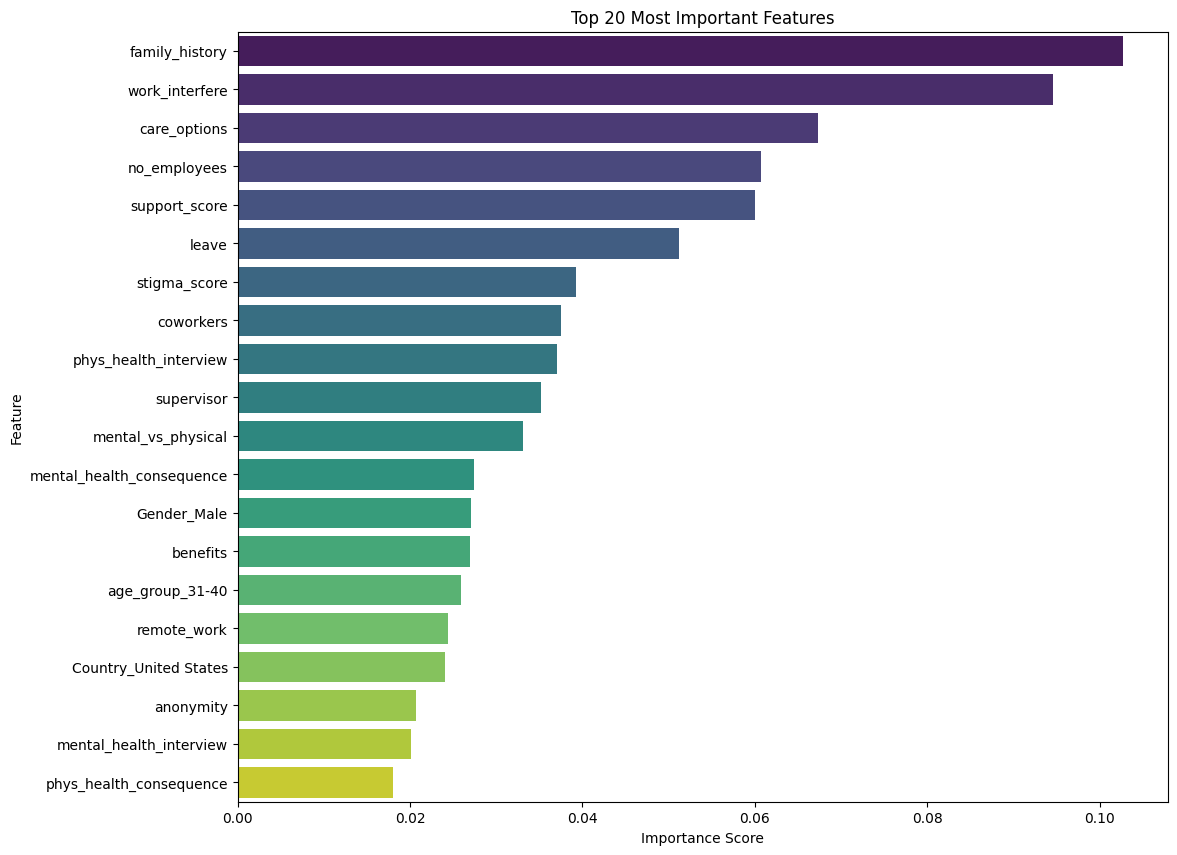

In [16]:
# Plot the top 20 most important features
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

In [17]:
# Select the names of the top 30 features
selected_features = feature_importance_df['feature'].head(30).tolist()

# Create new DataFrames with only the selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

print("Feature selection complete.")
print("Shape of X_train_selected:", X_train_selected.shape)
print("Shape of X_test_selected:", X_test_selected.shape)

Feature selection complete.
Shape of X_train_selected: (1007, 30)
Shape of X_test_selected: (252, 30)


In [18]:
# Define the path for our processed data
processed_data_path = '../data/processed/'

# Save the feature-selected training and testing sets
X_train_selected.to_csv(processed_data_path + 'X_train_selected.csv', index=False)
X_test_selected.to_csv(processed_data_path + 'X_test_selected.csv', index=False)

# Save the corresponding target variables
y_train.to_csv(processed_data_path + 'y_train.csv', index=False)
y_test.to_csv(processed_data_path + 'y_test.csv', index=False)

print("All feature-selected data has been saved successfully to the 'data/processed/' folder.")

All feature-selected data has been saved successfully to the 'data/processed/' folder.
